# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
import matplotlib.pyplot as plt
from cs231n.data_utils import load_CIFAR10

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
## Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

## Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del XTrain, yTrain
   del XTest, yTest
   print('Clear previously loaded data.')
except:
   pass

## Load the raw CIFAR-10 data.
cifar10Dir = 'cs231n/datasets/cifar-10-batches-py'
XTrain, yTrain, XTest, yTest = load_CIFAR10(cifar10Dir)

## As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', XTrain.shape)
print('Training labels shape: ', yTrain.shape)
print('Test data shape: ', XTest.shape)
print('Test labels shape: ', yTest.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


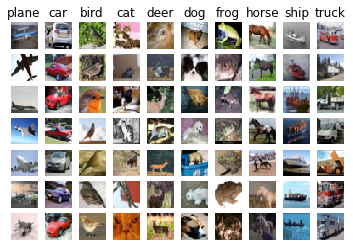

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
numClasses = len(classes)
samplesPerClass = 7

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(yTrain == y)
    idxs = np.random.choice(idxs, samplesPerClass, replace = False)
    for i, idx in enumerate(idxs):
        pltIdx = i * numClasses + y + 1
        plt.subplot(samplesPerClass, numClasses, pltIdx)
        plt.imshow(XTrain[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
numTraining = 5000
mask = range(numTraining)
XTrain = XTrain[mask]
yTrain = yTrain[mask]

numTest = 500
mask = range(numTest)
XTest = XTest[mask]
yTest = yTest[mask]

In [5]:
# Reshape the image data into rows
XTrain = np.reshape(XTrain, (XTrain.shape[0], -1))
XTest = np.reshape(XTest, (XTest.shape[0], -1))
print(XTrain.shape, XTest.shape)

(5000, 3072) (500, 3072)


In [6]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(XTrain, yTrain)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [7]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
distMat = classifier.computeDistancesTwoLoops(XTest)
print(distMat.shape)

(500, 5000)


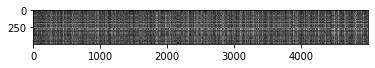

In [9]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(distMat, interpolation = 'none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**: *fill this in.*



In [10]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
yTestPred = classifier.predictLabels(distMat, k = 1)

# Compute and print the fraction of correctly predicted examples
numCorrect = np.sum(yTestPred == yTest)
accuracy = float(numCorrect) / numTest
print('Got %d / %d correct => accuracy: %f' % (numCorrect, numTest, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [11]:
yTestPred = classifier.predictLabels(distMat, k = 5)

# Compute and print the fraction of correctly predicted examples
numCorrect = np.sum(yTestPred == yTest)
accuracy = float(numCorrect) / numTest
print('Got %d / %d correct => accuracy: %f' % (numCorrect, numTest, accuracy))

Got 145 / 500 correct => accuracy: 0.290000


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**
We can also other distance metrics such as L1 distance.
The performance of a Nearest Neighbor classifier that uses L1 distance will not change if (Select all that apply.):
1. The data is preprocessed by subtracting the mean.
2. The data is preprocessed by subtracting the mean and dividing by the standard deviation.
3. The coordinate axes for the data are rotated.
4. None of the above.

*Your Answer*:

*Your explanation*:


In [12]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
distMatOne = classifier.computeDistancesOneLoop(XTest)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(distMat - distMatOne, ord = 'fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [13]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
distMatTwo = classifier.computeDistancesNoLoops(XTest)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(distMat - distMatTwo, ord = 'fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [14]:
# Let's compare how fast the implementations are
def timeFunction(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

twoLoopTime = timeFunction(classifier.computeDistancesTwoLoops, XTest)
print('Two loop version took %f seconds' % twoLoopTime)

oneLoopTime = timeFunction(classifier.computeDistancesOneLoop, XTest)
print('One loop version took %f seconds' % oneLoopTime)

noLoopTime = timeFunction(classifier.computeDistancesNoLoops, XTest)
print('No loop version took %f seconds' % noLoopTime)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 26.989115 seconds
One loop version took 36.342736 seconds
No loop version took 0.375756 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [15]:
numFolds = 5
kChoices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

XTrainFolds = []
yTrainFolds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, XTrainFolds and      #
# yTrainFolds should each be lists of length numFolds, where                   #
# yTrainFolds[i] is the label vector for the points in XTrainFolds[i].         #
# Hint: Look up the numpy array_split function.                                #
################################################################################

## Splitting up the data into folds.
XTrainFolds = np.split(XTrain, numFolds)
yTrainFolds = np.split(yTrain, numFolds)

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# kToAccuracies[k] should be a list of length numFolds giving the different
# accuracy values that we found when using that value of k.
kToAccuracies = {}
numSplit = XTrain.shape[0] / numFolds
accK = np.zeros((len(kChoices), numFolds), dtype = np.float)


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm numFolds times,    #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the kToAccuracies dictionary.                                 #
################################################################################

for indexK, k in enumerate(kChoices):
    for i in range(numFolds):
        
        ## Choose the training set.
        trainSet = np.concatenate((XTrainFolds[ : i] + XTrainFolds[i + 1 :]))
        labelSet = np.concatenate((yTrainFolds[ : i] + yTrainFolds[i + 1 :]))
        
        ## Train the classifier on the above training set.
        classifier.train(trainSet, labelSet)
        
        ## Compute predictions.
        yPredFold = classifier.predict(XTrainFolds[i], k = k, numLoops = 0)
        numCorrect = np.sum(yPredFold == yTrainFolds[i])
        accK[indexK, i] = float(numCorrect) / numSplit
    
    kToAccuracies[k] = accK[indexK]
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(kToAccuracies):
    for accuracy in kToAccuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.257000
k = 3, accuracy = 0.263000
k = 3, accuracy = 0.273000
k = 3, accuracy = 0.282000
k = 3, accuracy = 0.270000
k = 5, accuracy = 0.265000
k = 5, accuracy = 0.275000
k = 5, accuracy = 0.295000
k = 5, accuracy = 0.298000
k = 5, accuracy = 0.284000
k = 8, accuracy = 0.272000
k = 8, accuracy = 0.295000
k = 8, accuracy = 0.284000
k = 8, accuracy = 0.298000
k = 8, accuracy = 0.290000
k = 10, accuracy = 0.272000
k = 10, accuracy = 0.303000
k = 10, accuracy = 0.289000
k = 10, accuracy = 0.292000
k = 10, accuracy = 0.285000
k = 12, accuracy = 0.271000
k = 12, accuracy = 0.305000
k = 12, accuracy = 0.285000
k = 12, accuracy = 0.289000
k = 12, accuracy = 0.281000
k = 15, accuracy = 0.260000
k = 15, accuracy = 0.302000
k = 15, accuracy = 0.292000
k = 15, accuracy = 0.292000
k = 15, accuracy = 0.285000
k = 20, accuracy = 0.268000
k = 20, accu

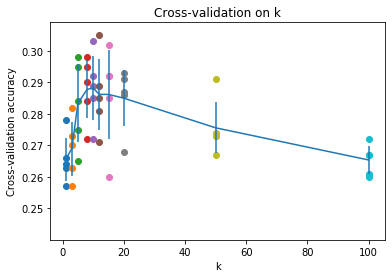

In [16]:
# plot the raw observations
for k in kChoices:
    accuracies = kToAccuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuraciesMean = np.array([np.mean(v) for k, v in sorted(kToAccuracies.items())])
accuraciesStd = np.array([np.std(v) for k, v in sorted(kToAccuracies.items())])
plt.errorbar(kChoices, accuraciesMean, yerr = accuraciesStd)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [17]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
bestK = 1

classifier = KNearestNeighbor()
classifier.train(XTrain, yTrain)
yTestPred = classifier.predict(XTest, k = bestK)

# Compute and display the accuracy
numCorrect = np.sum(yTestPred == yTest)
accuracy = float(numCorrect) / numTest
print('Got %d / %d correct => accuracy: %f' % (numCorrect, numTest, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


**Inline Question 3**
Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The training error of a 1-NN will always be better than that of 5-NN.
2. The test error of a 1-NN will always be better than that of a 5-NN.
3. The decision boundary of the k-NN classifier is linear.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

*Your Answer*:

*Your explanation*: